# Loading coding toolboxes

In [1]:
options(warn = -1) # Suppress warnings

library(reshape)
library(ggplot2)
library(dplyr)

options(repr.plot.width = 25, repr.plot.height = 8) # set plot size


Attaching package: ‘dplyr’


The following object is masked from ‘package:reshape’:

    rename


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Part 1: Introduction to epidemiology and the  SIW model 

    Before getting started with the activity we will introduce a little bit of background
    S: Susceptible (i.e. Healthy)
    I: Infectious (i.e. Infected)
    W: Withdrawn (i.e. a person can be withdrawn from population by vacine/dead/isolated quarantine)
    
    beta: transmission rate (susceptible -> infectious)
    gamma: withdrawal rate (infectious -> withdrawn)
    
    R-repoductive number: beta*S/gamma
    R0-Basic reporodcutive number: beta/gamma

# What's what: setting up the data 

In [2]:
beta  = 1.5   # transmission rate
gamma = 0.2   # withdrawal rate

data            = data.frame("S" = as.double(), "I" = as.double(), "W" = as.double())

data["city_A",] = c(0.99, 0.01, 0) 
data["city_B",] = c(0.80, 0.10, 0.10)
data["city_C",] = c(0.50, 0.20, 0.30)
data["city_D",] = c(0.60, 0.30, 0.10)

data$city  = rownames(data)
data$beta  = beta
data$gamma = gamma

data


,S,I,W,city,beta,gamma
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
city_A,0.99,0.01,0.0,city_A,1.5,0.2
city_B,0.80,0.10,0.1,city_B,1.5,0.2
city_C,0.50,0.20,0.3,city_C,1.5,0.2
city_D,0.60,0.30,0.1,city_D,1.5,0.2


# Modeling changes to the population over time

In [4]:
# Note: Refer to slide X for model explanation

time_step = function(data){
    
    for (city in data$city){
        S = data[city, "S"] # assign S
        I = data[city, "I"] # assign I
        W = data[city, "W"] # assign W
        
        beta  = data[city, "beta"]
        gamma = data[city, "gamma"]
        
        data[city, "S"] = S - beta*S*I           # change in S
        data[city, "I"] = I + beta*S*I - gamma*I # change in I
        data[city, "W"] = W + gamma*I            # change in W
    }
    
    return(data)
}


# See the change - plottng changes 

,S,I,W,city,beta,gamma
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
city_A,0.99,0.01,0.0,city_A,1.5,0.2
city_B,0.80,0.10,0.1,city_B,1.5,0.2
city_C,0.50,0.20,0.3,city_C,1.5,0.2
city_D,0.60,0.30,0.1,city_D,1.5,0.2


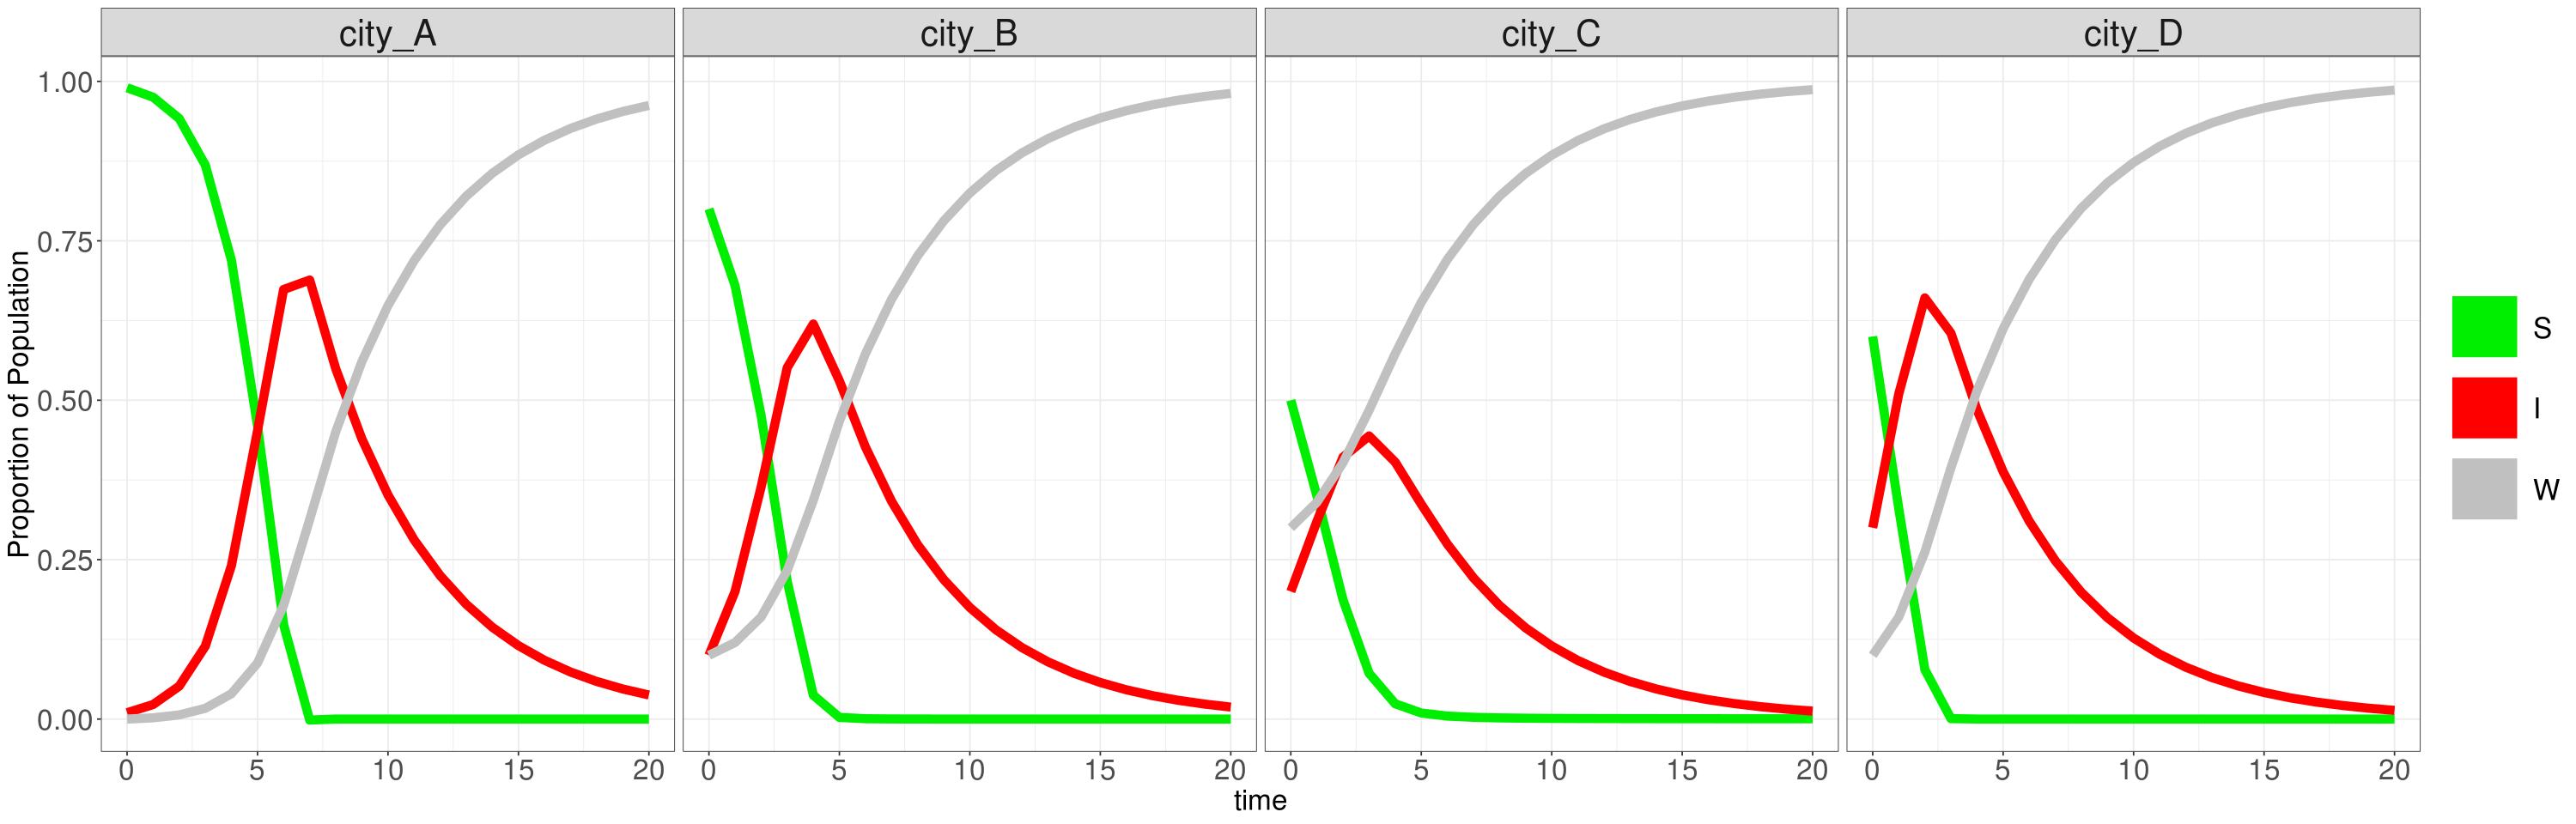

In [5]:
# 1. Setting up the data -----------------

beta  = 1.5   # transmission rate
gamma = 0.2   # recovery rate

data            = data.frame("S" = as.double(), "I" = as.double(), "W" = as.double())
data["city_A",] = c(0.99, 0.01, 0) 
data["city_B",] = c(0.80, 0.10, 0.10)
data["city_C",] = c(0.50, 0.20, 0.30)
data["city_D",] = c(0.60, 0.30, 0.10)

data$city  = rownames(data)
data$beta  = beta
data$gamma = gamma

data

# 2. Model the dynamics over a given time -----------------

master      = data            # save starting values to master
master$time = 0               # add time column 

for (i in 1:20){              # for 20 time points:
    a      = time_step(data)  # call function and save updated values to "a"
    data   = a                # re-initialize "data"
    a$time = i                # add time column
    master = rbind(master, a) # save updated values to "master"
}

# 3. See the changes -----------------

ggplot(melt(master[,c("S", "I", "W", "city", "time")], id = c("time", "city")), aes(x = time,  y = value, color = variable )) +  # assign x- and y-values
    geom_line(size = 3) + facet_grid(cols = vars(city)) + theme_bw() +                        # plot line graph with each city in separate plots
    theme(axis.text    = element_text(size = 20),                         # increase axis text size     
          axis.title   = element_text(size = 20),                         # increase axis title size
          legend.text  = element_text(size = 20),                         # increase legent text size
          legend.title = element_blank(),                                 # remove title in legend
          strip.text   = element_text(size=25)) +                         # increase plot title size
    ylab("Proportion of Population") +                                    # set y-axis title
    scale_color_manual(values = c("#00ee00", "#ff0000", "#c0c0c0")) +     # set colors
    guides(color = guide_legend(override = list(size = 20)))              # enlarge legend symbols

# Note: Refer to slide X for plot explanation

# Part 2: Shock to system

    
    Two types of events:
        1. Shock      (i.e. one instance)
        2. Behavorial (i.e. long-term change)
    
    Shock is a one-time event where transmission can occur (i.e. alters S and I)
    
        Example: concert
        
        - event_beta: the rate of transmission for one instance during event
        
            data[city, "S"] = data[city, "S"] - (events[event, "event_beta"] * data[city, "S"] * data[city, "I"])
            data[city, "I"] = data[city, "I"] + (events[event, "event_beta"] * data[city, "S"] * data[city, "I"])
        
            1. = 0: no change
            2. > 0: transmission during event
            
    Behavorial is an ongoing situation where tranmission/withdrawal rates change (i.e. alters beta and/or gamma)
    
        Example: state opens, restaurants open
    
        - effect_of_beta: changes beta for the rest of simulation
        
            data[city, "beta"]  = data[city, "beta"]  * events[event, "effect_on_beta"]
        
            1. > 1: increases beta (i.e. higher tranmission rate)
            2. < 1: decreases beta (i.e. lower transmission rate)
            3. = 1: no change in beta
            
        - effect of gamma: changes gamma for rest of simulation
        
            data[city, "gamma"] = data[city, "gamma"] * events[event, "effect_on_gamma"]
            
            1. > 1: increases gamma (i.e. higher withdrawal rate)
            2. < 1: decreases gamma (i.e. lower withdrawal rate) 
            3. = 1: no change in gamma
    


# Examples of events

In [6]:
# 1. Initialize table -----------------

events = data.frame("event_name"      = as.character("no change"), 
                    "type"            = as.character("behavorial"), 
                    "effect_on_beta"  = 1, 
                    "effect_on_gamma" = 1, 
                    "event_beta"      = 0)


# 2. Add events -----------------

temp <- data.frame("concert"              , "shock"      , 1  , 1  , 1.2)
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("state_open"           , "behavorial" , 1.3, 1  , 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("hospital_full"        , "behavorial" , 1  , 0.9, 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("improved_treatments"  , "behavorial" , 1  , 1.2, 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("natural_disaster"     , "shock"      , 1  , 1  , 2  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("distancing_compliance", "behavorial" , 0.6, 1  , 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("vaccine"              , "behavorial" , 0.1, 1  , 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("civil_unrest"         , "shock"      , 1  , 1  , 1.3)
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("schools_reopen_temp"  , "shock"      , 1  , 1  , 1.2)
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)


# 3. Convert to numbers -----------------

events$effect_on_beta  = as.double(events$effect_on_beta)
events$effect_on_gamma = as.double(events$effect_on_gamma)
events$event_beta      = as.double(events$event_beta)


events

,event_name,type,effect_on_beta,effect_on_gamma,event_beta
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
no change,no change,behavorial,1.0,1.0,0.0
concert,concert,shock,1.0,1.0,1.2
state_open,state_open,behavorial,1.3,1.0,0.0
hospital_full,hospital_full,behavorial,1.0,0.9,0.0
improved_treatments,improved_treatments,behavorial,1.0,1.2,0.0
state_closes,state_closes,behavorial,0.7,1.0,0.0
natural_disaster,natural_disaster,shock,1.0,1.0,2.0
distancing_compliance,distancing_compliance,behavorial,0.6,1.0,0.0
vaccine,vaccine,behavorial,0.1,1.0,0.0


# Modeling changes in beta and gamma

In [12]:
# This function selects a random event and applies it to a random city, changing its corresponding parameters (i.e. S, I, beta, gamma). 

event = function(data, time){   
    
    # Select random event
    event = sample(events$event_name, 1)

    # Select random city
    city  = sample(data$city, 1)
    
    if (events[event, "type"] == "shock") { message("Shock!") }
    else { message("Behavior change!") }
    
    message(paste(event, "is happening in", city))
    
    message(paste("effect on beta:", events[event, "effect_on_beta"]))
    message(paste("effect on gamma:", events[event, "effect_on_gamma"]))
    message(paste("event_beta:", events[event, "event_beta"]))
    
    message("\n")
    
    # Change beta/gamma 
    
    message(paste("At time", time, ", if there had been no event: -------"))
    message(paste0(capture.output(data), collapse = "\n"))
    
    data[city, "beta"]  = data[city, "beta"]  * events[event, "effect_on_beta"]
    data[city, "gamma"] = data[city, "gamma"] * events[event, "effect_on_gamma"]
    
    data[city, "S"] = data[city, "S"] - (events[event, "event_beta"] * data[city, "S"] * data[city, "I"])
    data[city, "I"] = data[city, "I"] + (events[event, "event_beta"] * data[city, "S"] * data[city, "I"])
    
    message("But with event: -------")
    message(paste0(capture.output(data), collapse = "\n"))

    return(data)

}

# This function allows us to see how this shock impacts the city over time
time_step_event = function(data, time){
    
    data = event(data, time)
    
    for (city in rownames(data)){
        S = data[city, "S"]
        I = data[city, "I"]
        W = data[city, "W"]

        beta  = data[city, "beta"]
        gamma = data[city, "gamma"]
        
        data[city, "S"] = S - beta*S*I
        data[city, "I"] = I + beta*S*I - gamma*I
        data[city, "W"] = W + gamma*I

    }
    
    return(data)
}


# Running the shocks

Behavior change!

state_closes is happening in city_C

effect on beta: 0.7

effect on gamma: 1

event_beta: 0




At time 5 , if there had been no event: -------

                  S         I          W beta gamma   city
city_A 7.196262e-01 0.2405835 0.03979028  1.5   0.2 city_A
city_B 3.746293e-02 0.6195179 0.34301920  1.5   0.2 city_B
city_C 2.401142e-02 0.4030447 0.57294388  1.5   0.2 city_C
city_D 6.668904e-05 0.4848059 0.51512737  1.5   0.2 city_D

But with event: -------

                  S         I          W beta gamma   city
city_A 7.196262e-01 0.2405835 0.03979028 1.50   0.2 city_A
city_B 3.746293e-02 0.6195179 0.34301920 1.50   0.2 city_B
city_C 2.401142e-02 0.4030447 0.57294388 1.05   0.2 city_C
city_D 6.668904e-05 0.4848059 0.51512737 1.50   0.2 city_D



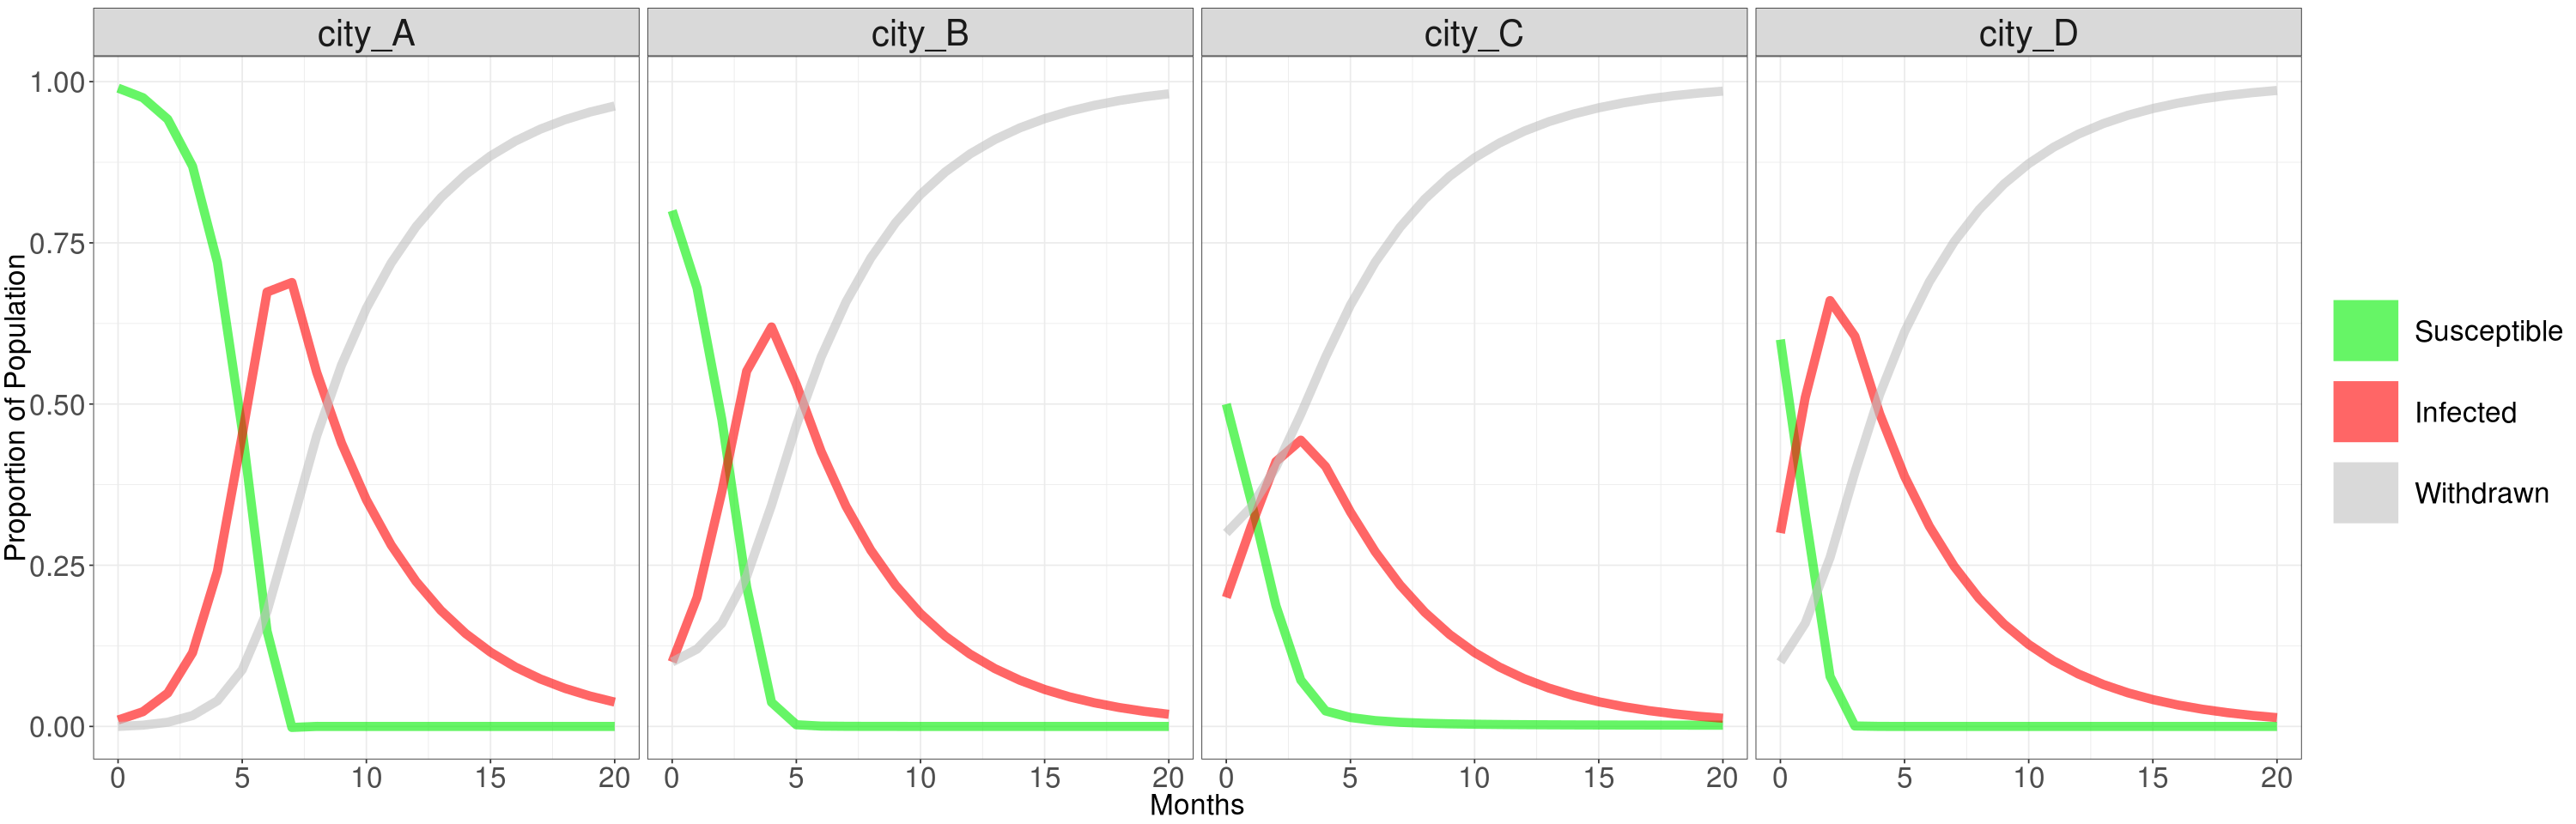

In [22]:
# Note: Refer to slide X 

# 1. Initialize our data (same as Part 1) -----------------

beta  = 1.5  # initialize beta
gamma = 0.2  # initialize gamma

data            = data.frame("S" = as.double(), "I" = as.double(), "W" = as.double())
data["city_A",] = c(0.99, 0.01, 0)
data["city_B",] = c(0.80, 0.10, 0.10)
data["city_C",] = c(0.50, 0.20, 0.30)
data["city_D",] = c(0.60, 0.30, 0.10)

data$beta       = beta
data$gamma      = gamma
data$city       = rownames(data)

original.data   = data         # save this data - we will need this again

#3. Model over time( WITH event) -----------------

data = original.data

yes_event      = data                           # save starting values to master
yes_event$time = 0                              # add time column 

for (month in 1:24){                                # for a given time:
    if (month == 5){ a = time_step_event(data, month) } # have event happen @ time = 5
    else { a = time_step(data) }                # other times happen normally
    data   = a                                  # re-initialize "data"
    a$time = month                                  # add time column
    yes_event = rbind(yes_event, a)             # save new values to "master"
}
  
yes_event$has_event = TRUE


# 4. Visualize our results -----------------

ggplot(melt(yes_event[,c("city", "has_event", "time", "S", "I", "W")], id = c("city", "has_event", "time")), 
       aes(x = time,  y = value, color = variable)) +  # assign x- and y-values
    geom_line(alpha = 0.6, size = 3) + 
    facet_grid(cols = vars(city)) + theme_bw() +                             # plot line graph with each city in separate plots
    theme(axis.text    = element_text(size = 20),                            # increase axis text size     
          axis.title   = element_text(size = 20),                            # increase axis title size
          legend.text  = element_text(size = 20),                            # increase legent text size
          legend.title = element_blank(),                                    # remove title in legend
          strip.text   = element_text(size=25)) +                            # increase plot title size
    ylab("Proportion of Population") +                                       # set y-axis title
    scale_color_manual(values = c("#00ee00", "#ff0000", "#c0c0c0"),
                       labels = c("Susceptible", "Infected", "Withdrawn")) +        # set colors
    guides(color = guide_legend(override = list(size = 20))) +               # enlarge legend symbols
    scale_linetype_manual(values=c("solid", "dotted"),
                          labels = c("yes_event")) + xlab("Months")


# Explore on your own time

Behavior change!

state_open is happening in city_C

At time 5 , if there had been no event: -------

                  S         I          W beta gamma   city
city_A 7.196262e-01 0.2405835 0.03979028  1.5   0.2 city_A
city_B 3.746293e-02 0.6195179 0.34301920  1.5   0.2 city_B
city_C 2.401142e-02 0.4030447 0.57294388  1.5   0.2 city_C
city_D 6.668904e-05 0.4848059 0.51512737  1.5   0.2 city_D

But with event: -------

                  S         I          W beta gamma   city
city_A 7.196262e-01 0.2405835 0.03979028 1.50   0.2 city_A
city_B 3.746293e-02 0.6195179 0.34301920 1.50   0.2 city_B
city_C 2.401142e-02 0.4030447 0.57294388 1.95   0.2 city_C
city_D 6.668904e-05 0.4848059 0.51512737 1.50   0.2 city_D



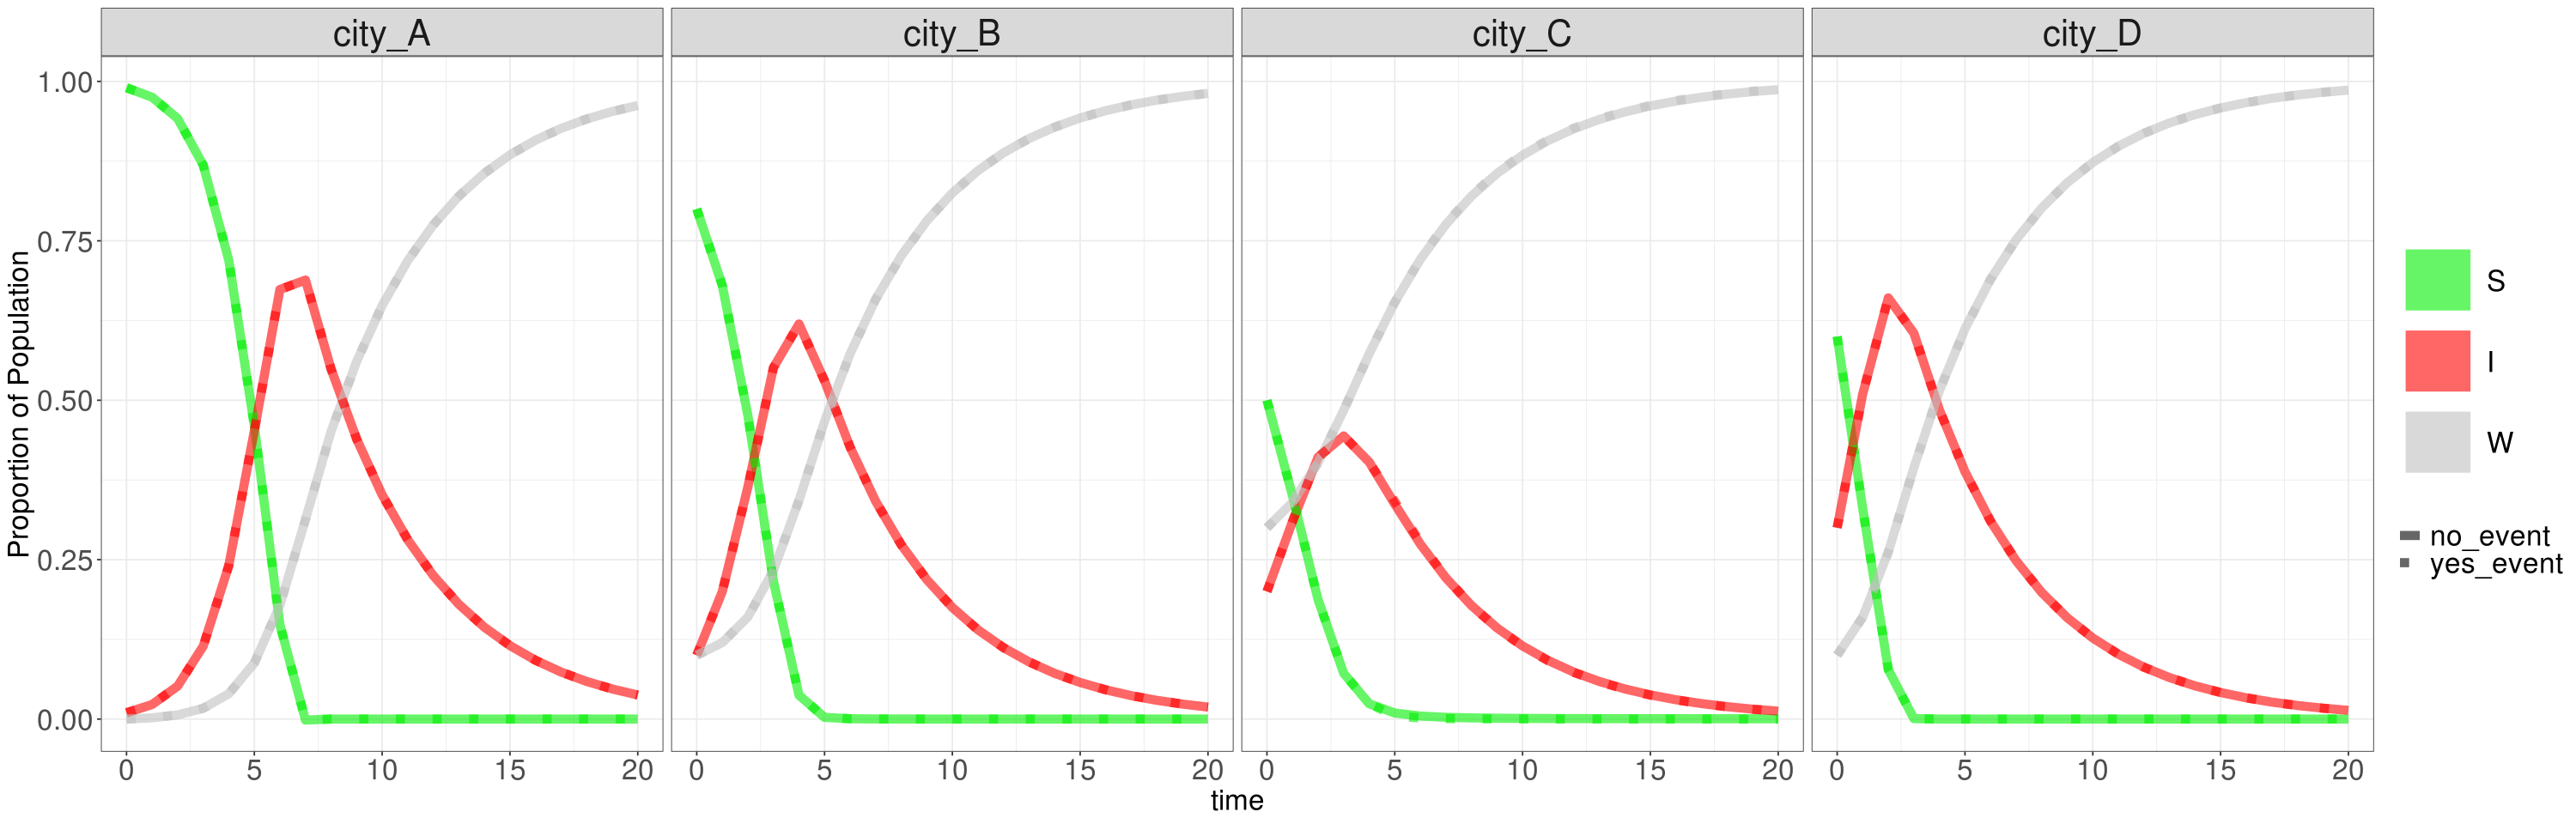

In [142]:
# 1. Initialize our data (same as Part 1) -----------------

beta  = 1.5  # initialize beta
gamma = 0.2  # initialize gamma

data            = data.frame("S" = as.double(), "I" = as.double(), "W" = as.double())
data["city_A",] = c(0.99, 0.01, 0)
data["city_B",] = c(0.80, 0.10, 0.10)
data["city_C",] = c(0.50, 0.20, 0.30)
data["city_D",] = c(0.60, 0.30, 0.10)

data$beta       = beta
data$gamma      = gamma
data$city       = rownames(data)

original.data   = data         # save this data - we will need this again


# 2. Model over time ( WITHOUT event) -----------------

no_event      = data                            # save starting values to master
no_event$time = 0                               # add time column 

for (i in 1:20){                                # for 20 time points:
    a      = time_step(data)                    # call function and save new values to "a"
    data   = a                                  # re-initialize "data"
    a$time = i                                  # add time column
    no_event = rbind(no_event, a)               # save new values to "master"
}
no_event$has_event  = FALSE


#3. Model over time( WITH event) -----------------

data = original.data

yes_event      = data                           # save starting values to master
yes_event$time = 0                              # add time column 

for (i in 1:20){                                # for a given time:
    if (i == 5){ a = time_step_event(data, i) } # have event happen @ time = 5
    else { a = time_step(data) }                # other times happen normally
    data   = a                                  # re-initialize "data"
    a$time = i                                  # add time column
    yes_event = rbind(yes_event, a)             # save new values to "master"
}
  
yes_event$has_event = TRUE


# 4. Visualize our results -----------------

master = rbind(no_event, yes_event)

ggplot(melt(master[,c("city", "has_event", "time", "S", "I", "W")], id = c("city", "has_event", "time")), 
       aes(x = time,  y = value, linetype = has_event, color = variable)) +  # assign x- and y-values
    geom_line(alpha = 0.6, size = 3) + 
    facet_grid(cols = vars(city)) + theme_bw() +                             # plot line graph with each city in separate plots
    theme(axis.text    = element_text(size = 20),                            # increase axis text size     
          axis.title   = element_text(size = 20),                            # increase axis title size
          legend.text  = element_text(size = 20),                            # increase legent text size
          legend.title = element_blank(),                                    # remove title in legend
          strip.text   = element_text(size=25)) +                            # increase plot title size
    ylab("Proportion of Population") +                                       # set y-axis title
    scale_color_manual(values = c("#00ee00", "#ff0000", "#c0c0c0")) +        # set colors
    guides(color = guide_legend(override = list(size = 20))) +               # enlarge legend symbols
    scale_linetype_manual(values=c("solid", "dotted"),
                          labels = c("no_event", "yes_event"))
